# Data Science Capstone Project

## Predicting Hockey scores using Data Science


In this project we will attenpt to preict NHL hockey results using machine learning algorithms

First we import the required libraries

In [1]:

# import libraries
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## Load Data

We now load in the source datasets required

In [2]:
""" 

Loads 3 datasets and merges them    

Parameters:
    messages_filepath - contains the filepath to the messages.csv file
    categories_filepath - contains the filepath to the categories.csv file

Returns:
    df - dataframe containing the merged datasets

"""

# load team dataset
team = pd.read_csv('game_teams_stats.csv')

# load goalie dataset
goalie = pd.read_csv('game_goalie_stats.csv')

# load skater dataset
skater = pd.read_csv('game_skater_stats.csv')

# Clean Data

Each dataset now needs to be cleaned in preparation for merging.

We start with the team data:

In [3]:
team.dtypes

game_id                     int64
team_id                     int64
HoA                        object
won                          bool
settled_in                 object
head_coach                 object
goals                     float64
shots                     float64
hits                      float64
pim                       float64
powerPlayOpportunities    float64
powerPlayGoals            float64
faceOffWinPercentage      float64
giveaways                 float64
takeaways                 float64
blocked                   float64
startRinkSide              object
dtype: object

In [4]:
team.nunique()

game_id                   23735
team_id                      37
HoA                           2
won                           2
settled_in                    3
head_coach                  146
goals                        13
shots                        60
hits                         77
pim                         110
powerPlayOpportunities       17
powerPlayGoals                8
faceOffWinPercentage        428
giveaways                    51
takeaways                    36
blocked                      44
startRinkSide                 2
dtype: int64

In [5]:
print('HoA unique values: ') 
print(team['HoA'].value_counts())
print('won unique values: ') 
print(team['won'].value_counts())
print('settled_in unique values: ') 
print(team['settled_in'].value_counts())
print('startRinkSide unique values: ') 
print(team['startRinkSide'].value_counts())

HoA unique values: 
away    26305
home    26305
Name: HoA, dtype: int64
won unique values: 
False    26947
True     25663
Name: won, dtype: int64
settled_in unique values: 
REG    40306
OT     12256
tbc       48
Name: settled_in, dtype: int64
startRinkSide unique values: 
left     26852
right    23366
Name: startRinkSide, dtype: int64


We can see that the categorical columns "HoA' and "startRinkSide" have 2 values and "settled_in" has 3 values (with 'tbc' accounting for very few responses). The boolean column "won" is our target variable so we can replace it with a clearer column called "Result".  "HoA and "StartRinkSide" can both be replaced with integer values.  We replace "HoA" with a column named "Home" which has a value of 1 when the team is at home and 0 when they are away.  We can now use the column in our predictions without having to set up dummy variables.  The same can be done with "startRinkSide".  We can replace "settled_in" with 3 dummy variables named "overtime", "regulation" and "overtime_tbc".  The column "head_coach" is not required so can be dropped.

In [6]:
# Clean Team data

# replace catagorical features with dummy variables
team['home'] = np.where(team['HoA']=='home',True,False).astype(int)
team['away'] = np.where(team['HoA']=='away',True,False).astype(int)
team['start_on_left'] = np.where(team['startRinkSide']=='left',True,False).astype(int)
team['start_on_right'] = np.where(team['startRinkSide']=='right',True,False).astype(int)
team['overtime_required'] = np.where(team['settled_in']=='OT',True,False).astype(int)
team['regulation'] = np.where(team['settled_in']=='REG',True,False).astype(int)
team['overtime_tbc'] = np.where(team['settled_in']=='tbc',True,False).astype(int)
team.drop(team[team.overtime_tbc == 1].index, inplace=True)
# drop original features
team.drop(columns=['HoA','settled_in','startRinkSide','head_coach','overtime_tbc'],inplace=True)

# add prefix to all features except game_id and team_id to easily identify them as being related to the team dataset
# also rename team_won to team_result to better reflect the content of the column
team = team.add_prefix('team_')
team.rename(columns={'team_game_id':'game_id','team_team_id':'team_id'},inplace=True)

Then we look at the goalie data:

In [7]:
goalie.describe(include='all')

,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage
count,5.665600e+04,5.665600e+04,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,52554,56517.000000,51913.000000,56459.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26277,NaN,NaN,NaN
mean,2.010748e+09,8.468184e+06,16.902146,3369.154564,0.021075,0.000159,0.085851,27.684235,25.203562,4.078032,0.776529,20.342965,0.850925,22.133313,4.693589,NaN,90.112653,84.258532,91.039223
std,6.068775e+06,7.417587e+03,11.235659,734.192491,0.145223,0.012603,0.610103,8.825602,8.650819,3.201827,1.046156,7.577797,1.105461,7.757074,3.435020,NaN,7.798010,22.668988,8.253391
min,2.000020e+09,8.445275e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
25%,2.006020e+09,8.462055e+06,8.000000,3525.000000,0.000000,0.000000,0.000000,23.000000,20.000000,2.000000,0.000000,16.000000,0.000000,17.000000,2.000000,NaN,87.096774,75.000000,87.500000
50%,2.011021e+09,8.470320e+06,16.000000,3598.000000,0.000000,0.000000,0.000000,28.000000,26.000000,4.000000,0.000000,21.000000,1.000000,22.000000,4.000000,NaN,91.428571,92.857143,92.307692
75%,2.016021e+09,8.473607e+06,24.000000,3600.000000,0.000000,0.000000,0.000000,33.000000,31.000000,6.000000,1.000000,25.000000,1.000000,27.000000,7.000000,NaN,95.000000,100.000000,96.153846


We can see there are negative values in "shortHandedSaves".  We will need to drop the rows containing these values as they can't be correct.

We also need to aggregate the data so that there is only 1 row per game_id.

Once this is done the percentages will need to be recalculated.

In [8]:
# Clean Goalie data
# Add goalie counter feature and drop decision feature as it is already in the team dataset
goalie['goalies_used'] = 1
goalie.drop(columns=['decision'],inplace=True)

# drop rows with negative values in shortHandedSaves
goalie.drop(goalie[goalie.shortHandedSaves<0].index, inplace=True)

# handle multiple goalies per match by grouping by game_id 
goalie = goalie.groupby(by=['game_id', 'team_id']).sum()

# recalculate and tidy feature names for save_percentage, power_play_save_percentage, 
#   even_strength_save_percentage and time_on_ice
# drop player_id, decision and old percentage and timeOnIce columns
goalie['save_percentage'] = goalie['saves'] / goalie['shots']
goalie['power_play_save_percentage'] = goalie['powerPlaySaves'] / goalie['powerPlayShotsAgainst']
goalie['even_strength_save_percentage'] = goalie['evenSaves'] / goalie['evenShotsAgainst']
goalie['time_on_ice'] = goalie['timeOnIce'] / goalie['goalies_used']
goalie.drop(columns=['player_id','timeOnIce','savePercentage', \
                     'powerPlaySavePercentage','evenStrengthSavePercentage'], inplace = True)

# add prefix to all features except game_id and team_id to easily identify them as being related to the goalie dataset
goalie = goalie.add_prefix('goalie_')
goalie.rename(columns={'goalie_game_id':'game_id','goalie_team_id':'team_id'},inplace=True)

Then we look at the skater data:

In [9]:
skater.describe(include='all')

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
count,9.458300e+05,9.458300e+05,945830.000000,945830.000000,945830.000000,945830.000000,945830.000000,547723.000000,945830.000000,945830.000000,...,945830.000000,547723.000000,547723.000000,945830.000000,945830.000000,547723.000000,945830.000000,945830.000000,945830.000000,945830.000000
mean,2.010763e+09,8.469436e+06,16.862985,988.705195,0.262792,0.154644,1.664201,1.304696,0.037124,0.070543,...,3.345550,0.391313,0.475580,0.004924,0.005195,0.798327,-0.007727,807.715360,80.117924,100.871911
std,6.072766e+06,7.299758e+03,11.146468,310.968101,0.533979,0.408620,1.547529,1.462937,0.196857,0.276856,...,6.176884,0.671742,0.765434,0.070568,0.072288,1.095038,1.094068,245.388009,95.408978,118.131458
min,2.000020e+09,8.444894e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000
25%,2.006020e+09,8.466181e+06,8.000000,787.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,650.000000,0.000000,0.000000
50%,2.011021e+09,8.470626e+06,16.000000,999.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,809.000000,47.000000,60.000000
75%,2.016030e+09,8.475169e+06,24.000000,1198.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,...,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,968.000000,133.000000,169.000000
max,2.019041e+09,8.481813e+06,90.000000,4316.000000,5.000000,5.000000,16.000000,15.000000,4.000000,5.000000,...,46.000000,8.000000,8.000000,2.000000,2.000000,15.000000,7.000000,3411.000000,908.000000,1205.000000


Then we clean the skater data, again aggregating to ensure one row per game_id

In [10]:
# Clean Skater data
# drop duplicate rows
skater.drop_duplicates(inplace=True)

# drop columns already represented in team dataset
skater.drop(columns=['goals','shots','hits','powerPlayGoals','penaltyMinutes', \
                     'takeaways','giveaways','blocked','plusMinus'], inplace=True)

# group features by team and game, using sum or mean as appropriate
skater = pd.merge(skater.groupby(by=['game_id', 'team_id']).agg({k: \
                        sum for k in ['assists','faceOffWins','faceoffTaken', \
                        'powerPlayAssists','shortHandedGoals','shortHandedAssists']}), \
                  skater.groupby(by=['game_id', 'team_id']).agg({l: \
                        'mean' for l in ['timeOnIce','evenTimeOnIce','shortHandedTimeOnIce', \
                        'powerPlayTimeOnIce']}),on = ['game_id', 'team_id'])

# add prefix to all features except game_id and team_id to easily identify them as being related to the skater dataset
skater = skater.add_prefix('skater_')
skater.rename(columns={'skater_game_id':'game_id','skater_team_id':'team_id'},inplace=True)

Then we merge the 3 datasets together.

In [11]:
# create a list of the datasets to be merged
dataframes = [team, goalie, skater]

# merge datasets
df = reduce(lambda left,right: pd.merge(left,right,on=['game_id','team_id'],
                                        how='inner'), dataframes)     

We drop the game_id and team_id columns as they are no longer required

In [12]:
# drop team_id and game_id as they are no longer required
df.drop(columns=['team_id','game_id'],inplace=True)

In [13]:
df


,team_won,team_goals,team_shots,team_hits,team_pim,team_powerPlayOpportunities,team_powerPlayGoals,team_faceOffWinPercentage,team_giveaways,team_takeaways,...,skater_assists,skater_faceOffWins,skater_faceoffTaken,skater_powerPlayAssists,skater_shortHandedGoals,skater_shortHandedAssists,skater_timeOnIce,skater_evenTimeOnIce,skater_shortHandedTimeOnIce,skater_powerPlayTimeOnIce
0,False,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,...,8,29,57,4,0,0,990.833333,841.388889,55.555556,93.888889
1,True,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,...,11,28,57,4,0,0,981.333333,836.777778,75.111111,69.444444
2,True,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,...,6,28,64,2,0,0,1002.222222,879.611111,28.444444,94.166667
3,False,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,...,5,36,64,2,1,1,999.222222,888.333333,75.333333,35.555556
4,True,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,...,8,21,46,2,0,0,986.666667,844.722222,53.333333,88.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52547,False,1.0,29.0,29.0,20.0,4.0,0.0,58.7,12.0,11.0,...,2,37,63,0,0,0,992.833333,816.277778,43.222222,133.333333
52548,True,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,...,7,25,51,0,0,0,993.333333,966.666667,26.666667,0.000000
52549,True,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,...,7,25,51,0,0,0,993.333333,966.666667,26.666667,0.000000
52550,False,1.0,33.0,28.0,0.0,1.0,0.0,51.0,13.0,6.0,...,1,26,51,0,0,0,1011.444444,978.111111,0.000000,33.333333


This now gives us a dataset containing 52,552 rows and 43 columns.

In [14]:
df.isna().sum()

team_won                                    0
team_goals                                  0
team_shots                                  0
team_hits                                4920
team_pim                                    0
team_powerPlayOpportunities                 0
team_powerPlayGoals                         0
team_faceOffWinPercentage               22133
team_giveaways                           4920
team_takeaways                           4920
team_blocked                             4920
team_home                                   0
team_away                                   0
team_start_on_left                          0
team_start_on_right                         0
team_overtime_required                      0
team_regulation                             0
goalie_assists                              0
goalie_goals                                0
goalie_pim                                  0
goalie_shots                                0
goalie_saves                      

Looking at the number of NA values in the dataframe we have some missing data, particularly in team_faceOffWinPercentage.  As approximately 40% of the values are missing we should drop this feature from the dataset.

In [15]:
# drop column team_faceOffWinPercentage
df.drop(columns=['team_faceOffWinPercentage'],inplace=True)

In [16]:
df.isna().sum()

team_won                                   0
team_goals                                 0
team_shots                                 0
team_hits                               4920
team_pim                                   0
team_powerPlayOpportunities                0
team_powerPlayGoals                        0
team_giveaways                          4920
team_takeaways                          4920
team_blocked                            4920
team_home                                  0
team_away                                  0
team_start_on_left                         0
team_start_on_right                        0
team_overtime_required                     0
team_regulation                            0
goalie_assists                             0
goalie_goals                               0
goalie_pim                                 0
goalie_shots                               0
goalie_saves                               0
goalie_powerPlaySaves                      0
goalie_sho

Rows with remaining null values could be dropped, or they could be populated with the average for that column.  As these rows account for over 10% of our dataset we should use the average to ensure other data is not lost.

In [17]:
# replace remaining null values with each column average
df = pd.concat([df.pop('team_won'), df.fillna(df.mean())], axis=1)

In [18]:
df.isna().sum().sum()

0

All null values have now been handled and the data is ready to be used to build our Machine Learning model.

In [19]:
df

,team_won,team_goals,team_shots,team_hits,team_pim,team_powerPlayOpportunities,team_powerPlayGoals,team_giveaways,team_takeaways,team_blocked,...,skater_assists,skater_faceOffWins,skater_faceoffTaken,skater_powerPlayAssists,skater_shortHandedGoals,skater_shortHandedAssists,skater_timeOnIce,skater_evenTimeOnIce,skater_shortHandedTimeOnIce,skater_powerPlayTimeOnIce
0,False,4.0,27.0,30.0,6.0,4.0,2.0,12.0,9.0,11.0,...,8,29,57,4,0,0,990.833333,841.388889,55.555556,93.888889
1,True,7.0,28.0,20.0,8.0,3.0,2.0,16.0,8.0,9.0,...,11,28,57,4,0,0,981.333333,836.777778,75.111111,69.444444
2,True,4.0,34.0,16.0,6.0,3.0,1.0,7.0,4.0,14.0,...,6,28,64,2,0,0,1002.222222,879.611111,28.444444,94.166667
3,False,3.0,33.0,17.0,8.0,2.0,1.0,5.0,6.0,14.0,...,5,36,64,2,1,1,999.222222,888.333333,75.333333,35.555556
4,True,4.0,29.0,17.0,9.0,3.0,1.0,13.0,5.0,20.0,...,8,21,46,2,0,0,986.666667,844.722222,53.333333,88.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52547,False,1.0,29.0,29.0,20.0,4.0,0.0,12.0,11.0,9.0,...,2,37,63,0,0,0,992.833333,816.277778,43.222222,133.333333
52548,True,4.0,20.0,36.0,2.0,0.0,0.0,7.0,8.0,21.0,...,7,25,51,0,0,0,993.333333,966.666667,26.666667,0.000000
52549,True,4.0,20.0,36.0,2.0,0.0,0.0,7.0,8.0,21.0,...,7,25,51,0,0,0,993.333333,966.666667,26.666667,0.000000
52550,False,1.0,33.0,28.0,0.0,1.0,0.0,13.0,6.0,7.0,...,1,26,51,0,0,0,1011.444444,978.111111,0.000000,33.333333


Our final dataset contains 52552 rows and 42 columns

# Exploring the Data

## Win/Loss Ratio

We can look at the proportion of wins and losses

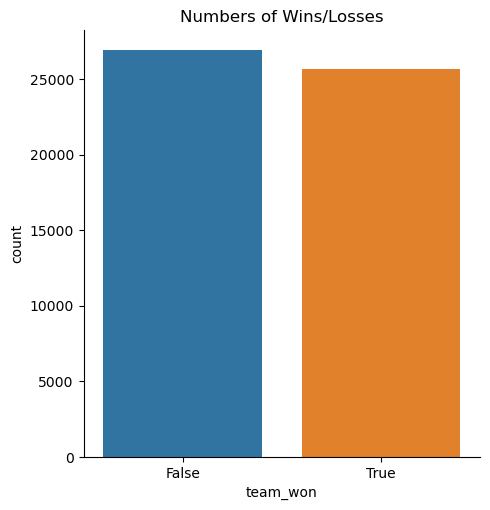

In [20]:
# plot the number of wins and losses
sns.catplot(data = df, x = 'team_won', kind='count')
plt.title("Numbers of Wins/Losses");

We can see from the above chart that there are slightly more losses than wins in the remaining dataset.  This is interesting as we would logically expect the same number of each result.  This suggests that the source dataset may not be entirely complete.

## Distribution of Team Goals

Scoring goals is an important factor in winning games, so it would be interesting to see how these are distributed through the results.

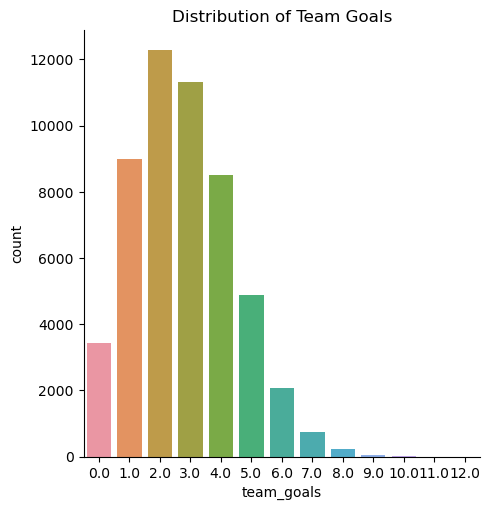

In [21]:
# plot the distribution of team goals
sns.catplot(data = df, x = 'team_goals', kind='count')
plt.title("Distribution of Team Goals");

## Comparison of Number of Goalies Used

The number of goalies used is likely to be relevant to predicting the outcome as normally a team only replaces their goalie if he is playing poorly.

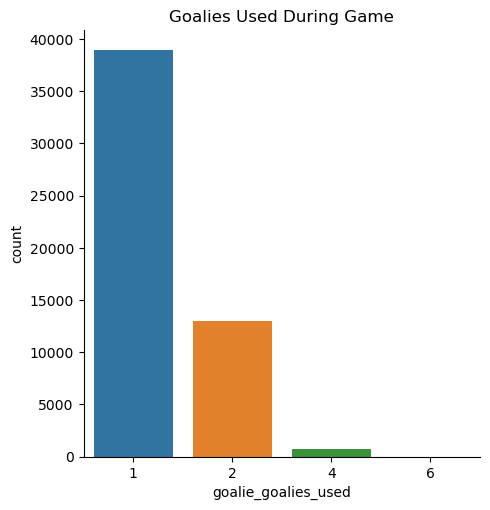

In [22]:
# plot the distribution of goalies used during a game
sns.catplot(data = df, x = 'goalie_goalies_used', kind='count')
plt.title("Goalies Used During Game");

We can see there is a reasonable number of games where more than one goalie is used.  it will be interesting to see if this does correlate with a reduction in the probablility of a win.
We can check this by comparing the distribution of wins and losses based on the number of goalies used.

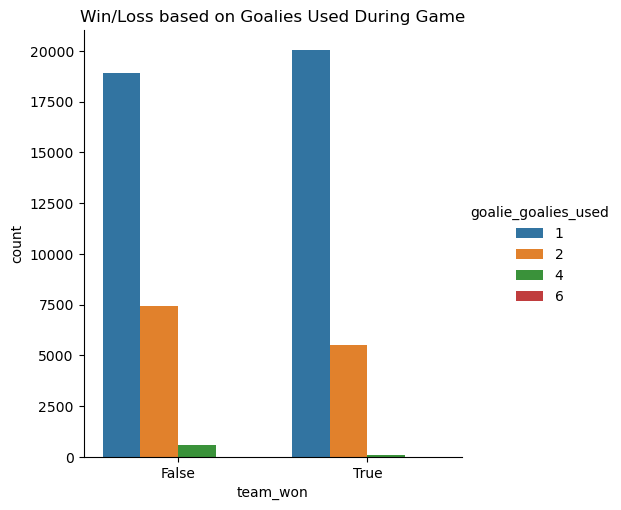

In [23]:
# plot the distribution of wins and losses split by the number of goalies used per game
sns.catplot(data = df, x = 'team_won', kind='count', hue='goalie_goalies_used')
plt.title("Win/Loss based on Goalies Used During Game");

As we can see, the number of wins is higher when only one goalie is used, and lower when more goalies are used.  This would suggest that using more than one goalie correlates to a reduced chance of the team winning the game.  However the act of changing the goalie may not cause the reduction, rather the same factors that result in the change of goalie may also result in the loss of the game.

### Number of Shots and Goals in a Game

We can look at the number of shots taken and goals scored to see how they compare (shot efficiency), and split this between wins and losses.

Text(0.5, 1.0, 'Number of Shots taken versus Goals Scored in Game')

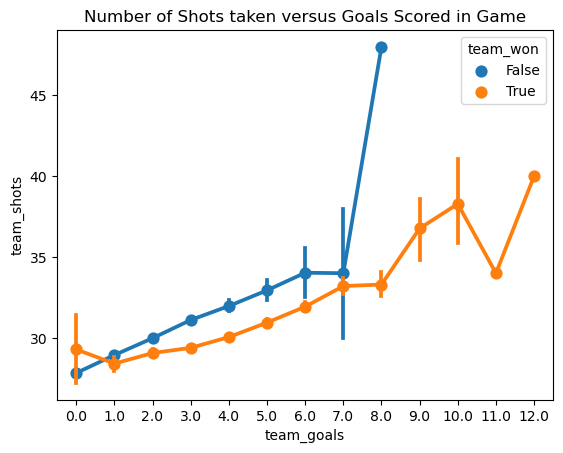

In [24]:
#plot shots in game as a boxplot
sns.pointplot(data = df, x = 'team_goals', y='team_shots', hue='team_won')
plt.title("Number of Shots taken versus Goals Scored in Game")

Winning teams appear to have a better shot efficiency, needing fewer shots to score their goals.  There is also as you would expect many higher values for goals scored for winning teams.

# Build Model

Now that we have our dataset we can begin to build our Machine Learning model.  First we build a pipeline function.

In [25]:
def build_model(classifier, params):
    
    """
    
    Builds the pipeline and carries out a grid search to improve the model
    
    Parameters:
        classifier - classifier to be used in model
    
    Returns:
        cv - Classifier object
    
    """
    
    pipeline = Pipeline([
        ('clf', MultiOutputClassifier(classifier)),
    ])
        
    # carry out grid search
    cv = GridSearchCV(pipeline, param_grid=params)
    
    return cv

Then we can create the training function.  As we intend to try different Classifiers we must factor this in to the code.

In [26]:
def train(X,y,model):
  
    """
    
    Creates the split between training and test data
    Fits the model using the training data
    Returns the trained model along with the test datasets
    
    Parameters:
        X - DataFrame of other columns 
        y - Result DataFrame 
        model - the ML model built in the build_model function
        
    Returns:
        model - model trained on the training datasets
        X_test - DataFrame containing test variables
        y_test - DataFrame containing test results
    
    """
    # need to identify type for X 
    X=X.astype('int')
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    model.fit(X_train, y_train)
      
    return model, X_test, y_test

The final function we require is the evaluation function, which we use to evaluate the effectiveness of the model.

In [27]:
def evaluate_model(model, name, X_test, y_test):

    """
    
    Evaluates the model and produces results for each column in a dataframe
    Results include an f1 score, precision score and a recall score for each
    category in the dataset
    
    Parameters:
        model - the model to be evaluated
        X_test - DataFrame containing test variables
        y_test - DataFrame containing test results
        
    Returns:
        results_df - DataFrame containing results of model testing
    
    """

    y_pred = model.predict(X_test)
    
    model_f1 = f1_score(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    results_df = pd.DataFrame()
    results_df = results_df.append({'f1 score' : model_f1, 'precision': model_precision, 'recall': model_recall},
                                    ignore_index = True)
    results_df.insert(loc=0,column='Model',value=name)
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_test,y_pred))
    
    
    return results_df


Now we split our data into the feature we wish to predict (y) and the features we will use for the prediction (X).
We also identify the Classifiers we wish to use.

In [28]:
X = df.drop(['team_won'], axis=1)
y = df[['team_won']]

classifiers_list = [
    RandomForestClassifier() 
    , KNeighborsClassifier()
    , MLPClassifier()
    , MultinomialNB()
] 

classifiers_name = [
    'Random Forest'
    , 'k-Nearest Neighbors'
    , 'Artificial Neural Network'
    , 'Multinomial Naive Bayes'
]

parameter_list = [
    {
        'clf__estimator__n_estimators' : [10,40]
        }
    , {
        'clf__estimator__n_neighbors': [5]
        }
    , {
        'clf__estimator__max_iter': [10]
        }
    , 
    {
        'clf__estimator__alpha': [0.01]
        }
    ]

Finally we run the entire process of building, training and evaluating the model with each different Classifier.

In [29]:
# create dataframe to hold overall results for each model
model_res_df = pd.DataFrame()

for name, clf, params in zip(classifiers_name, classifiers_list, parameter_list):
    print('Building model...')
    model = build_model(clf, params) 

    print('Training model with ' + name + ' classifier...')
    model, X_test, y_test = train(X, y, model)  

    print('Evaluating model...')
    results_df = evaluate_model(model, name, X_test, y_test)
    print('Evaluation completed.\n')
    model_res_df = pd.concat([model_res_df,results_df])

print('Process Complete.  Model comparison:')

model_res_df

Building model...
Training model with Random Forest classifier...
Evaluating model...
Confusion Matrix:
[[6301  507]
 [ 669 5661]]
Evaluation completed.

Building model...
Training model with k-Nearest Neighbors classifier...
Evaluating model...
Confusion Matrix:
[[5102 1616]
 [1189 5231]]
Evaluation completed.

Building model...
Training model with Artificial Neural Network classifier...
Evaluating model...
Confusion Matrix:
[[6703    6]
 [3750 2679]]
Evaluation completed.

Building model...
Training model with Multinomial Naive Bayes classifier...
Evaluating model...
Confusion Matrix:
[[3718 3016]
 [ 416 5988]]
Evaluation completed.

Process Complete.  Model comparison:


,Model,f1 score,precision,recall
0,Random Forest,0.905905,0.917802,0.894313
0,k-Nearest Neighbors,0.788573,0.763984,0.814798
0,Artificial Neural Network,0.587887,0.997765,0.416706
0,Multinomial Naive Bayes,0.777259,0.665038,0.935041


Based on the results we can see that all 4 models produce somewhat compelling predictions with f-scores between 0.78 and 0.91.

The Random Forest classifier appears to provide the best results, with the highest f1 Score and a significantly higher precision score as evidenced by the Confusion Matrix.  It also produces a high Recall score of 0.90.

The k-Nearest Neighbors classifier did not excel in any area, producing the 3rd best f1 and precision scores, and the highest number of false negative results.

The Artifical Neural Network classifier produced almost no false positives but the highest number of false negatives.  It also produced much less true positive and true negative values than the Random Forest.

The Naive Bayes classifier produced a high recall score but otherwise its results were mediocre.  

## Feature Selection


To enhance the model we can use feature selection to identify the most useful features.  Once this has been done we can re-run the model with the revised feature set and see if the results are improved.

In [30]:
# report which features were selected by RFE (Recursive Feature Eliminator)
# define RFE, we will use Multinomial Naive Bayes as the estimator
rfe = RFECV(
    estimator=MultinomialNB(),
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2,
)
# fit RFE
rfe.fit(X, y)
# display optimal number of features and identify columns selected
print(f"Optimal number of features: {rfe.n_features_}")
for i in range(X.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Optimal number of features: 36
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected True, Rank: 1.000
Column: 24, Selected True, Rank: 1.000
Colu

In [31]:
# using the columns selected above, produce a list of the column names
pos = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36]
colname = X.columns[pos]
print(colname)

Index(['team_goals', 'team_shots', 'team_hits', 'team_pim',
       'team_powerPlayOpportunities', 'team_powerPlayGoals', 'team_giveaways',
       'team_takeaways', 'team_blocked', 'team_home', 'team_away',
       'team_start_on_left', 'team_start_on_right', 'team_overtime_required',
       'team_regulation', 'goalie_assists', 'goalie_goals', 'goalie_pim',
       'goalie_shots', 'goalie_saves', 'goalie_powerPlaySaves',
       'goalie_shortHandedSaves', 'goalie_evenSaves',
       'goalie_shortHandedShotsAgainst', 'goalie_evenShotsAgainst',
       'goalie_powerPlayShotsAgainst', 'goalie_goalies_used',
       'goalie_save_percentage', 'goalie_power_play_save_percentage',
       'goalie_even_strength_save_percentage', 'skater_assists',
       'skater_faceOffWins', 'skater_faceoffTaken', 'skater_powerPlayAssists',
       'skater_shortHandedGoals', 'skater_shortHandedAssists'],
      dtype='object')


Using the Recursive Feature Eliminator with the Multinomial Naive Bayes we have reduced the list of features to 36.  We can now re-run the model using only these features to see if this improves the results.

In [32]:
X_refined = X[['team_goals', 'team_shots', 'team_hits', 'team_pim',
       'team_powerPlayOpportunities', 'team_powerPlayGoals', 'team_giveaways',
       'team_takeaways', 'team_blocked', 'team_home', 'team_away',
       'team_start_on_left', 'team_start_on_right', 'team_overtime_required',
       'team_regulation', 'goalie_assists', 'goalie_goals', 'goalie_pim',
       'goalie_shots', 'goalie_saves', 'goalie_powerPlaySaves',
       'goalie_shortHandedSaves', 'goalie_evenSaves',
       'goalie_shortHandedShotsAgainst', 'goalie_evenShotsAgainst',
       'goalie_powerPlayShotsAgainst', 'goalie_goalies_used',
       'goalie_save_percentage', 'goalie_power_play_save_percentage',
       'goalie_even_strength_save_percentage', 'skater_assists',
       'skater_faceOffWins', 'skater_faceoffTaken', 'skater_powerPlayAssists',
       'skater_shortHandedGoals', 'skater_shortHandedAssists']]

# create dataframe to hold overall results for each model
model_res_df = pd.DataFrame()

for name, clf, params in zip(classifiers_name, classifiers_list, parameter_list):
    print('Building model...')
    model = build_model(clf, params) 

    print('Training model with ' + name + ' classifier...')
    model, X_test, y_test = train(X_refined, y, model)  

    print('Evaluating model...')
    results_df = evaluate_model(model, name, X_test, y_test)
    print('Evaluation completed.\n')
    model_res_df = pd.concat([model_res_df,results_df])

print('Process Complete.  Model comparison:')

model_res_df

Building model...
Training model with Random Forest classifier...
Evaluating model...
Confusion Matrix:
[[6022  722]
 [ 774 5620]]
Evaluation completed.

Building model...
Training model with k-Nearest Neighbors classifier...
Evaluating model...
Confusion Matrix:
[[5200 1561]
 [1822 4555]]
Evaluation completed.

Building model...
Training model with Artificial Neural Network classifier...
Evaluating model...
Confusion Matrix:
[[6213  554]
 [ 224 6147]]
Evaluation completed.

Building model...
Training model with Multinomial Naive Bayes classifier...
Evaluating model...
Confusion Matrix:
[[5374 1315]
 [1279 5170]]
Evaluation completed.

Process Complete.  Model comparison:


,Model,f1 score,precision,recall
0,Random Forest,0.882538,0.886156,0.878949
0,k-Nearest Neighbors,0.729208,0.744768,0.714286
0,Artificial Neural Network,0.940483,0.917326,0.964841
0,Multinomial Naive Bayes,0.799443,0.797224,0.801675


The feature selection process has resulted in improved f1 scores for the Artificial Neural Network (0.59 to 0.94) and Naive Bayes (0.78 to 0.80).  Precision has improved for Naive Bayes (0.67 to 0.80).  The Recall score increased significantly for the Artificial Neural Network model (0.42 to 0.96).  Recall has dropped significantly for Naive Bayes (0.94 to 0.80).  Random Forest and k-Nearest Neighbors have seen a reduction in all 3 metrics.  

Using the reduced feature set on the Artificial Neural Network classifier model would appear to produce the best results overall with scores of 0.94, 0.92 and 0.96 across the three metrics, compared to the original Random Forest model that scored 0.90, 0.92 and 0.89 on the same 3 metrics.

# Conclusion

Working from our original 3 datasets we have merged, cleaned and investigated the data.  We have identified useful features and built a predictive model that achieved an f-score of 0.940, a precision of 0.917 and a recall of 0.965.

Further investigation could be carried out to optimise the number of features, and further feature engineering could be done to create useful datapoints such as shot efficiency (shots/goals).  The dataset could also be investigated further as there was clearly erroneous data that was excluded.  It is possible that there are other incorrect pieces of data that could be excluded.

Overall the final model is highly effective at identifying true positive and true negative outcomes in NHL hockey matches.